In [100]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

from scipy.optimize import quadratic_assignment#
from sklearn.manifold import MDS

# Graph extraction

In [147]:
file = pd.read_excel('Reduction Sequences/sequence_data_1-22-2024.xlsx')

In [148]:
refits = []

for index, row in file.iterrows():
    refit = row.iloc[0][:6]
    if refit not in refits: refits.append(refit)

print(refits)

['BT.1.4', 'BT.1.A', 'BT.1.C', 'BT.1.F', 'BT.2.6', 'BT.2.U', 'T-1_A_', 'T-1_18', 'T-1_19', 'T-1_47', 'T-1_57']


In [170]:
edge_lists = {refit:{} for refit in refits}

for i, row in file.iterrows():
    refit = row.iloc[0][:6]
    flake = row.iloc[0]
    edge_lists[refit][flake] = []
    j = 14
    while type(row.iloc[j])==str:
        edge_lists[refit][flake].append(row.iloc[j])
        j += 1

print(edge_lists[refits[0]])

{'BT.1.4-25.01': ['BT.1.4-25.02'], 'BT.1.4-25.02': ['BT.1.4-25.03'], 'BT.1.4-25.03': ['BT.1.4-25.04'], 'BT.1.4-25.04': ['BT.1.4-25.05'], 'BT.1.4-25.05': []}


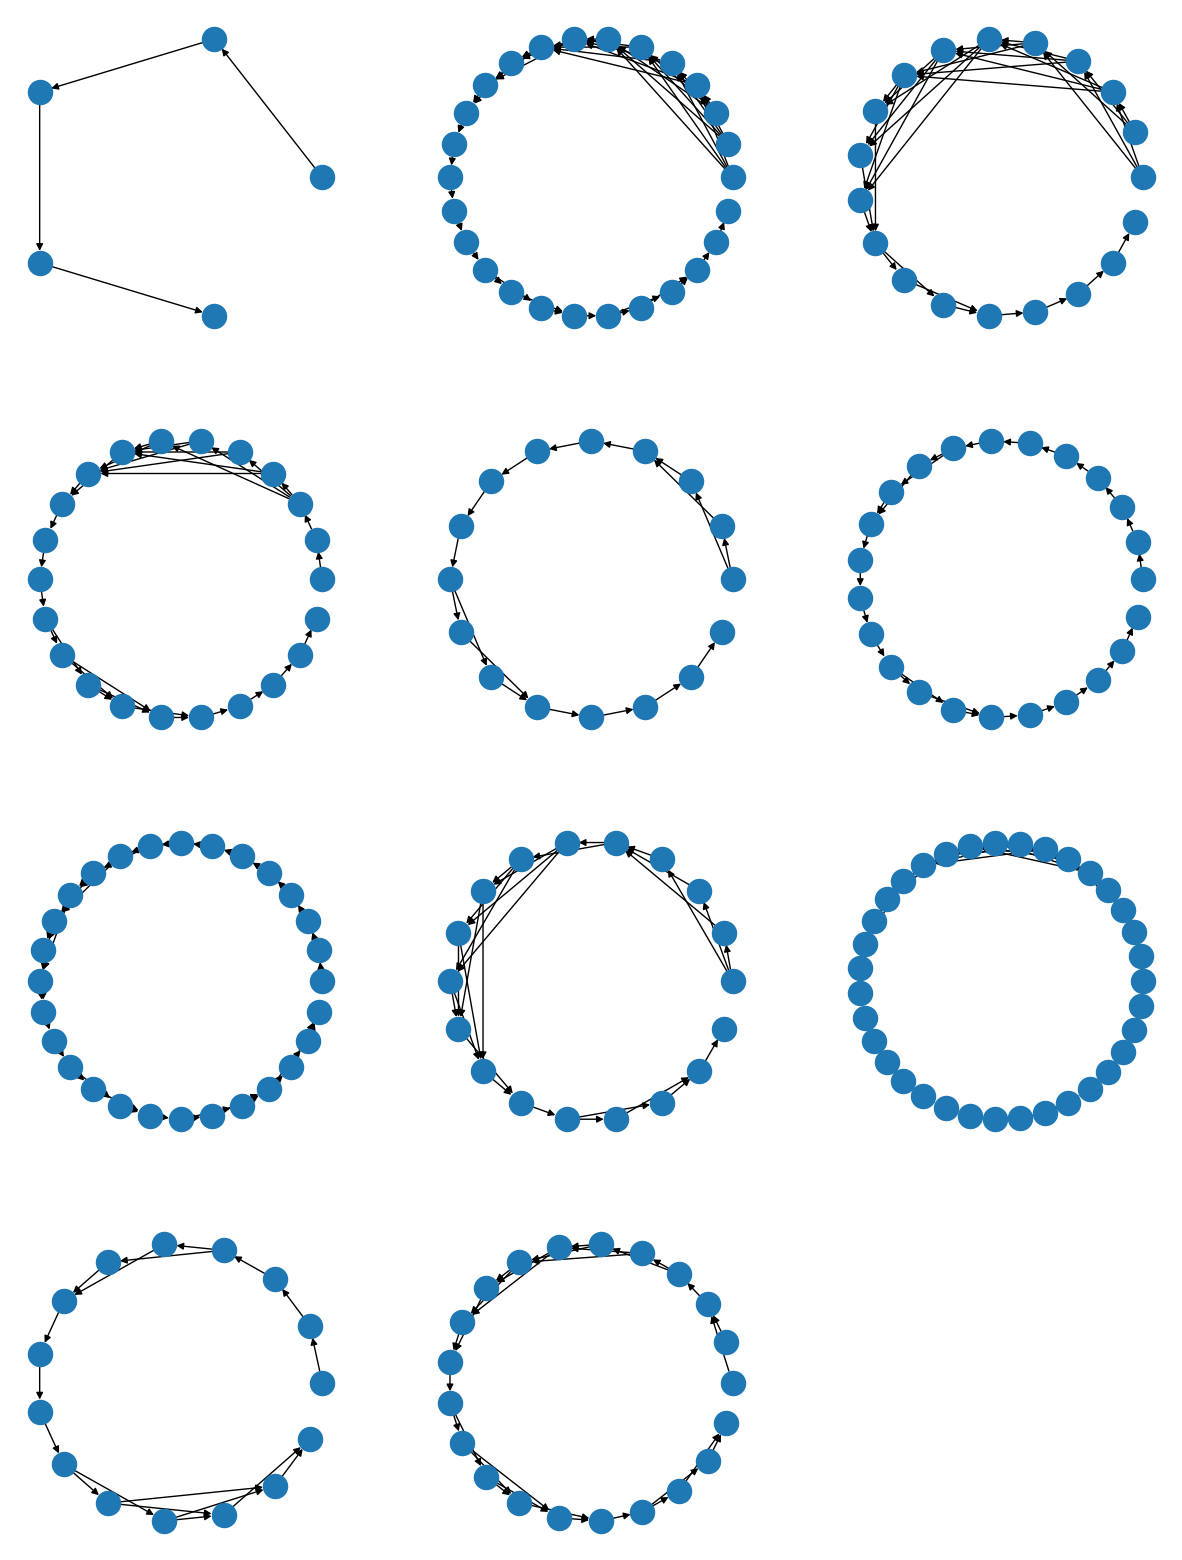

In [171]:
graphs = {refit:{} for refit in refits}
adjacency_mat = {refit:{} for refit in refits}

for refit in refits:
    graphs[refit] = nx.DiGraph(edge_lists[refit])
    a = nx.to_numpy_array(graphs[refit])
    for i in range(len(a)): 
        for j in range(i+1, len(a)):
            if a[i, j]>0. and a[j, i]>0.: a[i, j], a[j, i] = 0., 0. #discarding undirected edges
    adjacency_mat[refit] = a
    graphs[refit] = nx.DiGraph(adjacency_mat[refit])
    
fig = plt.figure(figsize=(15, 20))
for (i, refit) in enumerate(refits):
    plt.subplot(4, 3, i+1)
    nx.draw_circular(graphs[refit])

{0: (0, 0), 1: (0, 1), 2: (0, 2), 3: (0, 3), 4: (0, 4)}
{0: (0, 0), 1: (1, 0), 2: (2, 0), 3: (0, 1), 4: (1, 1), 5: (2, 1), 6: (3, 1), 7: (0, 2), 8: (1, 2), 9: (0, 3), 10: (1, 3), 11: (0, 4), 12: (0, 5), 13: (0, 6), 14: (0, 7), 15: (0, 8), 16: (0, 9), 17: (0, 10), 18: (1, 10), 19: (0, 11), 20: (0, 12), 21: (0, 13), 22: (1, 13), 23: (0, 14), 24: (0, 15), 25: (0, 16)}
{0: (0, 0), 1: (1, 0), 2: (0, 1), 3: (1, 1), 4: (2, 1), 5: (0, 2), 6: (1, 2), 7: (2, 2), 8: (0, 3), 9: (1, 3), 10: (2, 3), 11: (0, 4), 12: (0, 5), 13: (1, 5), 14: (0, 6), 15: (0, 7), 16: (0, 8), 17: (0, 9), 18: (0, 10)}
{0: (0, 0), 1: (0, 1), 2: (0, 2), 3: (0, 3), 4: (1, 3), 5: (2, 3), 6: (3, 3), 7: (0, 4), 8: (1, 4), 9: (0, 5), 10: (0, 6), 11: (0, 7), 12: (0, 8), 13: (0, 9), 14: (1, 9), 15: (0, 10), 16: (1, 10), 17: (0, 11), 18: (0, 12), 19: (0, 13), 20: (0, 14), 21: (0, 15)}
{0: (0, 0), 1: (0, 1), 2: (1, 1), 3: (0, 2), 4: (0, 3), 5: (0, 4), 6: (0, 5), 7: (0, 6), 8: (0, 7), 9: (0, 8), 10: (1, 8), 11: (0, 9), 12: (0, 10), 13

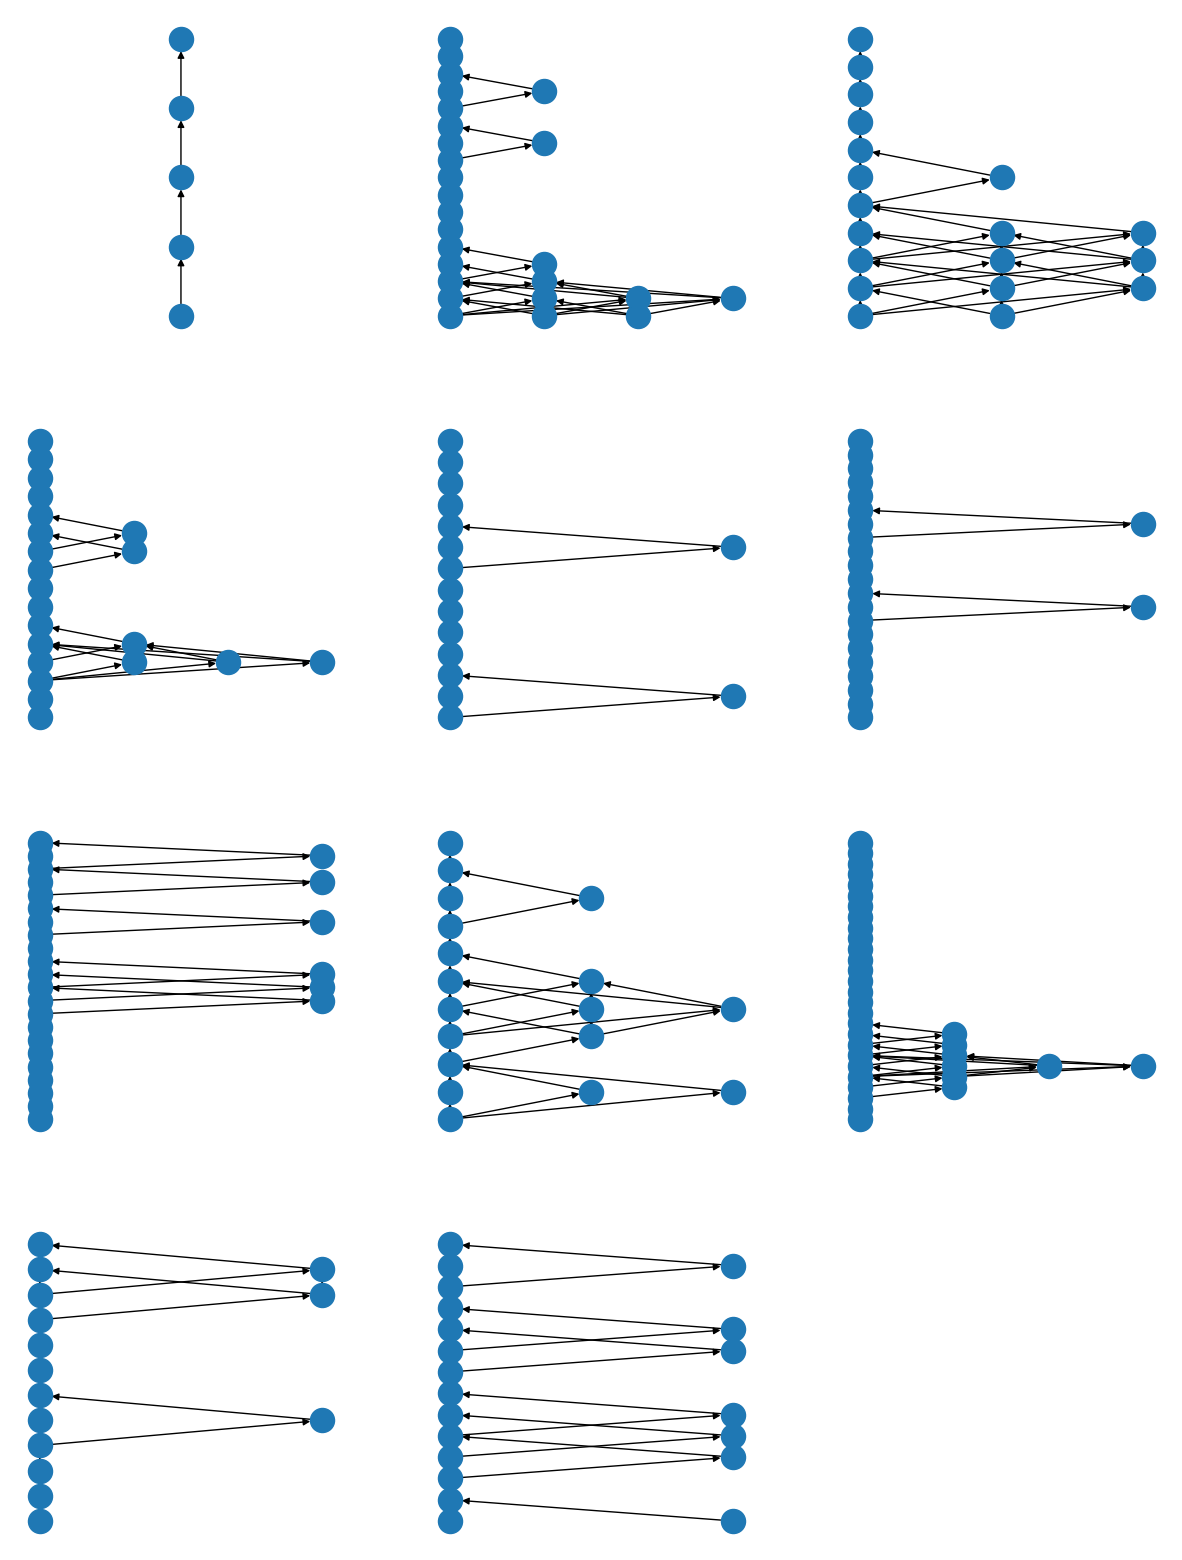

In [172]:
def draw_hasse(g):
    a = nx.to_numpy_array(g)
    pos = {}

    x = 0
    y = 0
    pos[0] = (x, y)
    for i in range(1, len(g)):
        if a[i-1, i] > 0.: 
            y += 1
            x = 0
        else : x += 1
        pos[i] = (x, y)
    print(pos)
    nx.draw(g, pos=pos)   

fig = plt.figure(figsize=(15, 20))
for (i, refit) in enumerate(refits):
    plt.subplot(4, 3, i+1)
    draw_hasse(graphs[refit])

print(refits)

In [173]:
dim = max([len(adjacency_mat[refit]) for refit in refits])
dataset = {refit:{} for refit in refits}

for refit in refits:
    a = adjacency_mat[refit]    

    
    a_new = np.zeros((dim, dim))
    a_new[:len(a), :][:, :len(a)] = a #embedding the graph in the common dimension
    dataset[refit]  = a_new

print(dataset[refits[0]])

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Distance matrix

In [174]:
def permutation_mat(permutation):
    mat = np.zeros((len(permutation), len(permutation)))
    for (i, j) in enumerate(permutation): mat[i, j] = 1.
    return(mat)

def graph_quotient_distance(a, b):
    res = quadratic_assignment(a, b, method='faq', options={'maximize': 'True',})
    return(np.linalg.norm(a)**2 - 2. * res.fun + np.linalg.norm(b)**2)

In [175]:
distance_mat = np.array([[int(graph_quotient_distance(dataset[ri], dataset[rj])) for ri in refits] for rj in refits])
print('Distance matrix =')
print(distance_mat)
distance_mat = (distance_mat + distance_mat.transpose()) / 2. - np.diag(np.diagonal(distance_mat))
print(' ')
print('Symmetrized distance matrix =')
print(distance_mat)

Distance matrix =
[[ 0 40 33 28 13 19 31 24 53 13 24]
 [40  6 27 26 29 25 27 28 33 29 20]
 [33 31  0 25 24 33 36 21 38 24 25]
 [28 20 25  9 21 18 27 31 32 14 13]
 [13 31 24 25 10 14 28 17 36 10 23]
 [19 27 35 24 14  7 24 28 33 19 24]
 [39 29 28 23 22 20  0 27 32 28 19]
 [24 28 21 21 17 24 25  0 35 20 19]
 [47 27 40 30 38 35 30 33  0 37 44]
 [13 31 26 16 12 21 24 18 39  0 12]
 [26 24 27 17 21 20 21 23 30 12  0]]
 
Symmetrized distance matrix =
[[ 0. 40. 33. 28. 13. 19. 35. 24. 50. 13. 25.]
 [40.  0. 29. 23. 30. 26. 28. 28. 30. 30. 22.]
 [33. 29.  0. 25. 24. 34. 32. 21. 39. 25. 26.]
 [28. 23. 25.  0. 23. 21. 25. 26. 31. 15. 15.]
 [13. 30. 24. 23.  0. 14. 25. 17. 37. 11. 22.]
 [19. 26. 34. 21. 14.  0. 22. 26. 34. 20. 22.]
 [35. 28. 32. 25. 25. 22.  0. 26. 31. 26. 20.]
 [24. 28. 21. 26. 17. 26. 26.  0. 34. 19. 21.]
 [50. 30. 39. 31. 37. 34. 31. 34.  0. 38. 37.]
 [13. 30. 25. 15. 11. 20. 26. 19. 38.  0. 12.]
 [25. 22. 26. 15. 22. 22. 20. 21. 37. 12.  0.]]


# Multi-dimensional scaling

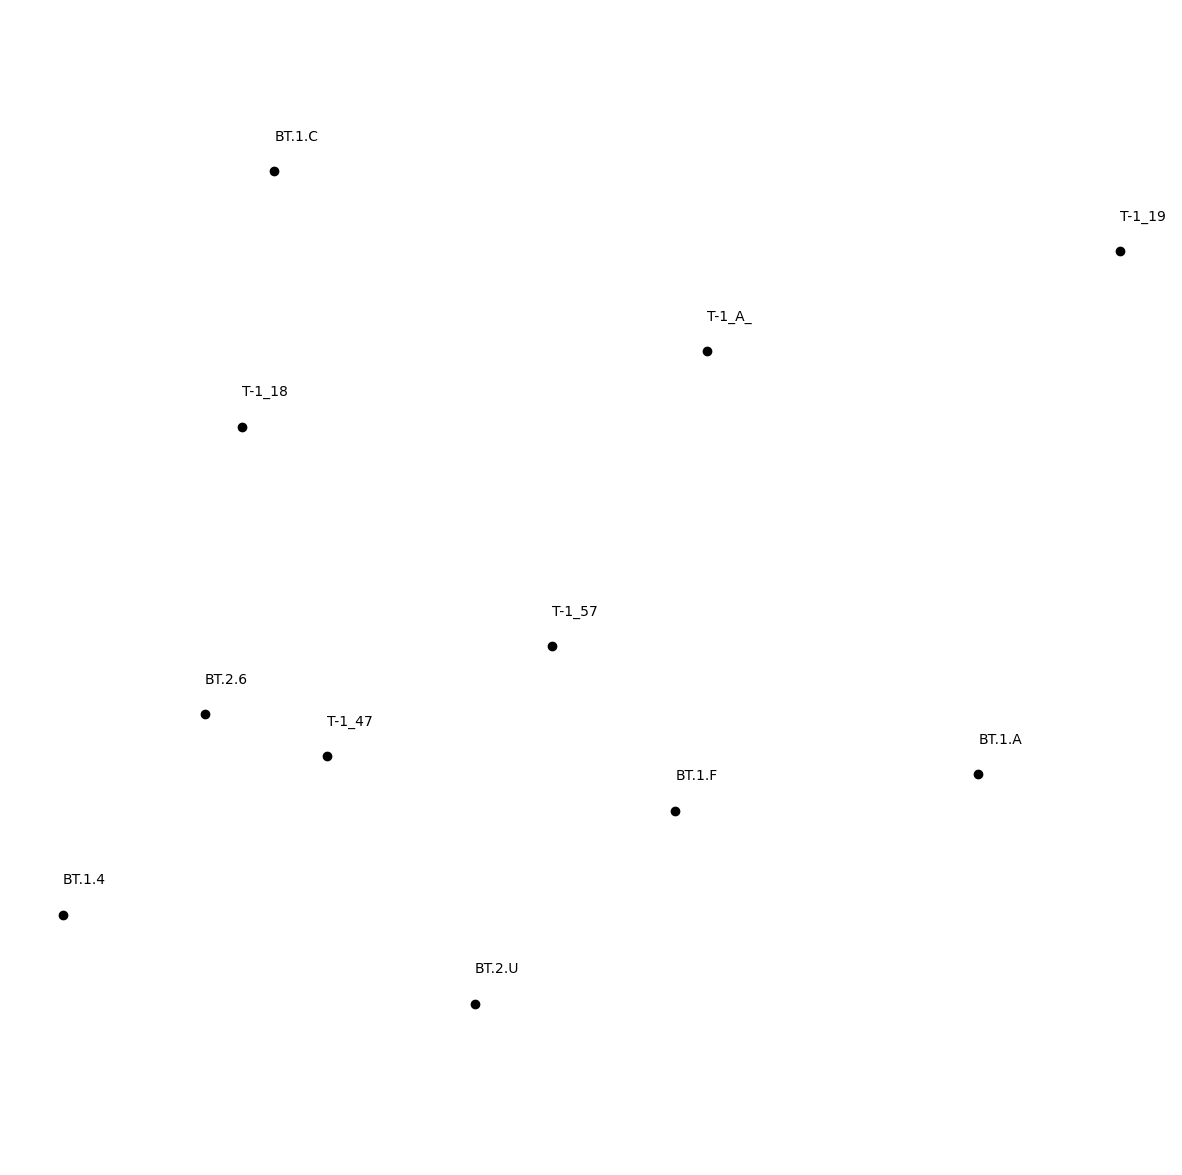

In [176]:
multidimensional_scaling = MDS(n_components=2, dissimilarity='precomputed', normalized_stress=False)
embedding = multidimensional_scaling.fit_transform(distance_mat)
embedding = embedding / np.max(embedding)

fig = plt.figure(figsize=(15, 15))
plt.plot(embedding[:, 0], embedding[:, 1], 'ko')
plt.axis('equal')
plt.axis('off')
for (i, coo) in enumerate(embedding): plt.text(coo[0], coo[1]+.05, refits[i])

# Diffusion maps

# Clustering